# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [5]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [6]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(375, 'family'), (948, 'values'), (814, 'serial'), (131, 'assume'), (283, 'currently'), (206, 'certainly'), (411, 'gary'), (307, 'details'), (352, 'end'), (789, 'save')]


In [7]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [22]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words 

Nb mots= 3252437


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer()
tmp = vectorizer2.fit_transform(newsgroups_train.data)


In [10]:
freq_dict = pd.Series(np.array(tmp.sum(axis=0))[0], index = sorted(vectorizer2.vocabulary_))
freq_dict.sort_values(ascending=False).head(20)

the     146532
to       75064
of       69034
ax       62406
and      57957
in       49401
is       43480
that     39264
it       33638
for      28600
you      26682
from     22670
edu      21321
on       20491
this     20121
be       19285
are      18616
not      18424
have     18074
with     17325
dtype: int64

### Plot the N frequent words and verify that its follows a Zipf law

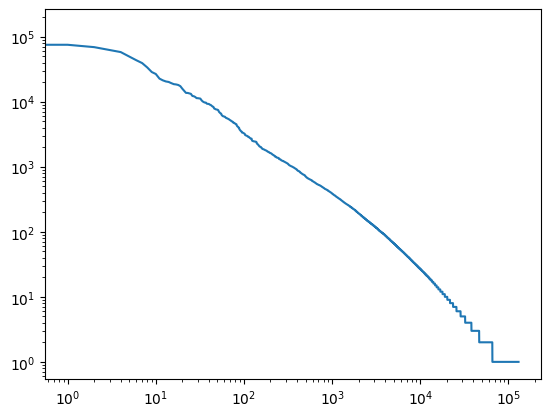

In [11]:
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.plot(freq_dict.sort_values(ascending=False).values)

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

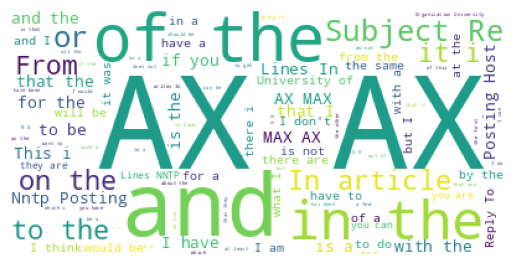

In [12]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

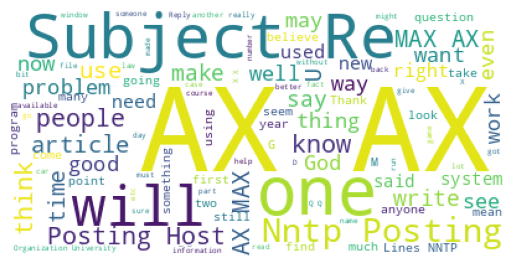

In [13]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

(-0.5, 399.5, 199.5, -0.5)

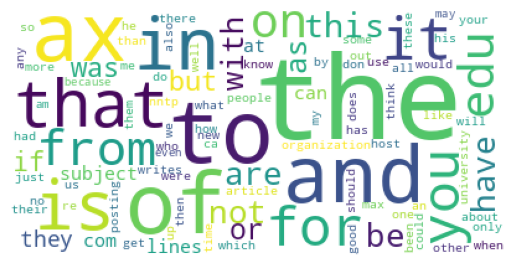

In [14]:
wordcloud = WordCloud(
    background_color='white',
    stopwords = STOPWORDS,
    max_words=100).generate_from_frequencies(frequencies=freq_dict)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

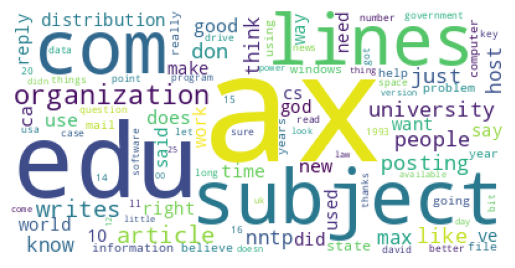

In [15]:
vectorizer2 = CountVectorizer(stop_words="english")
tmp = vectorizer2.fit_transform(newsgroups_train.data)
freq_dict = pd.Series(np.array(tmp.sum(axis=0))[0], index = sorted(vectorizer2.vocabulary_))
wordcloud = WordCloud(
    background_color='white',
    stopwords = STOPWORDS,
    max_words=100).generate_from_frequencies(frequencies=freq_dict)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


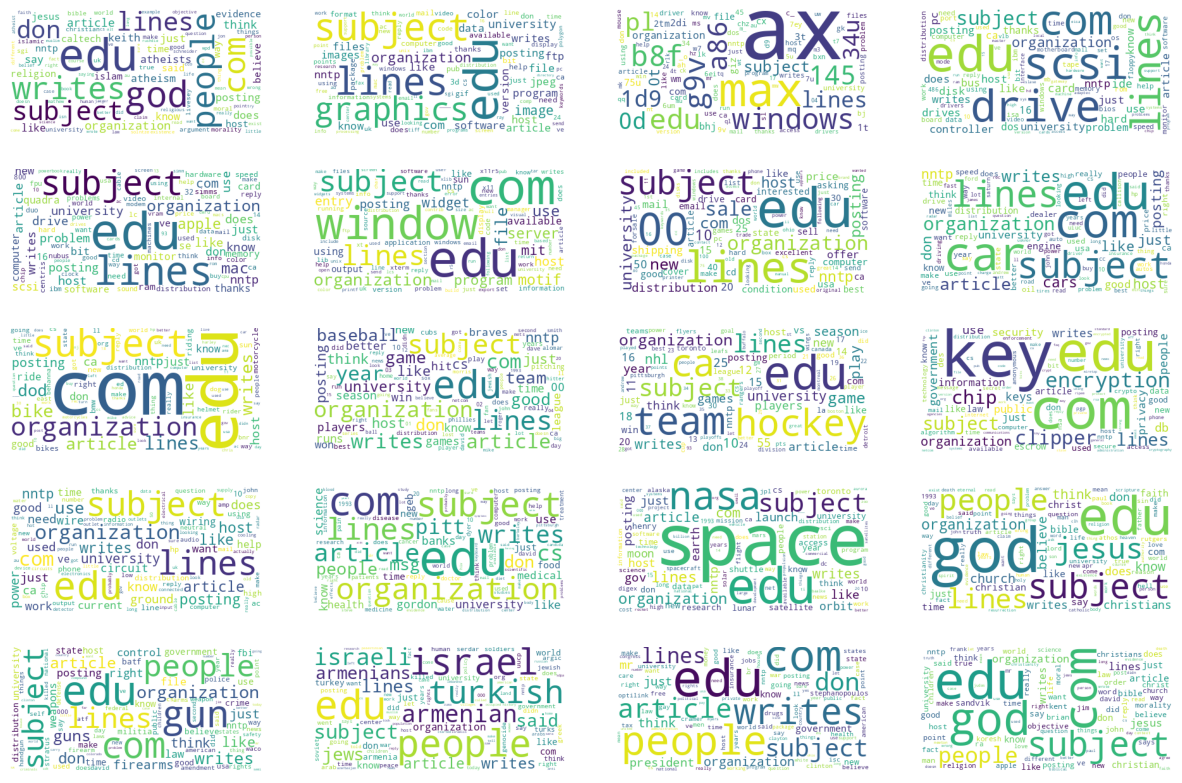

In [25]:
y = newsgroups_train.target
unique_classes = np.unique(y)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i, class_name in enumerate(unique_classes):
    class_idx = np.nonzero(y==unique_classes[class_name])
    vectorizer2 = CountVectorizer(stop_words="english")
    tmp = vectorizer2.fit_transform(data[class_idx])
    freq_dict = pd.Series(np.array(tmp.sum(axis=0))[0], index = sorted(vectorizer2.vocabulary_))
    wordcloud = WordCloud(
        background_color='white',
        stopwords = STOPWORDS,
        max_words=100).generate_from_frequencies(frequencies=freq_dict)
    ax[i].imshow(wordcloud)
    ax[i].axis("off")
    ax[i].set_title(f"Class name : {class_name}")

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [26]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

/home/charles/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.00481251, 0.00431009, 0.00048919, ..., 0.00481887, 0.01265084,
        0.00097928],
       [0.00369518, 0.01008388, 0.00139004, ..., 0.01172087, 0.00496925,
        0.00488701],
       [0.00390038, 0.00431445, 0.0023992 , ..., 0.00616613, 0.00405261,
        0.00336554],
       ...,
       [0.00050777, 0.00514748, 0.00089056, ..., 0.00369742, 0.00111354,
        0.        ],
       [0.00836867, 0.0035352 , 0.        , ..., 0.00816881, 0.0031431 ,
        0.01436739],
       [0.0015631 , 0.00515836, 0.00593669, ..., 0.00522794, 0.00822491,
        0.00154939]])

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

In [28]:
labels = newsgroups_train.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(newsgroups_train.data)} documents - {true_k} categories")

11314 documents - 20 categories


Most important words for each cluster

## Qualitative Analysis

In [29]:
pred = kmeans.predict(vectors)
pred = pd.Series(pred)

Text(0.5, 1.0, 'Répartition des différents document dans les 20 clusters')

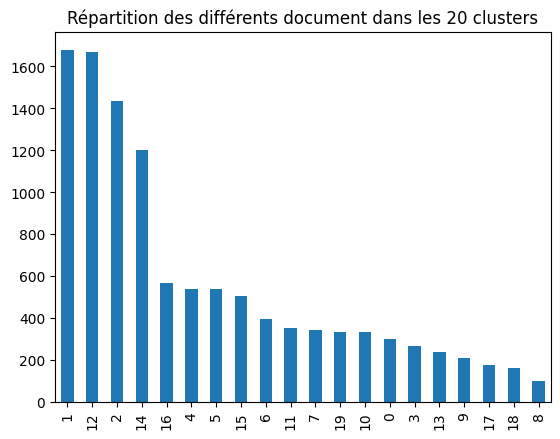

In [30]:
pred.value_counts().plot.bar()
plt.gca().set_title('Répartition des différents document dans les 20 clusters')

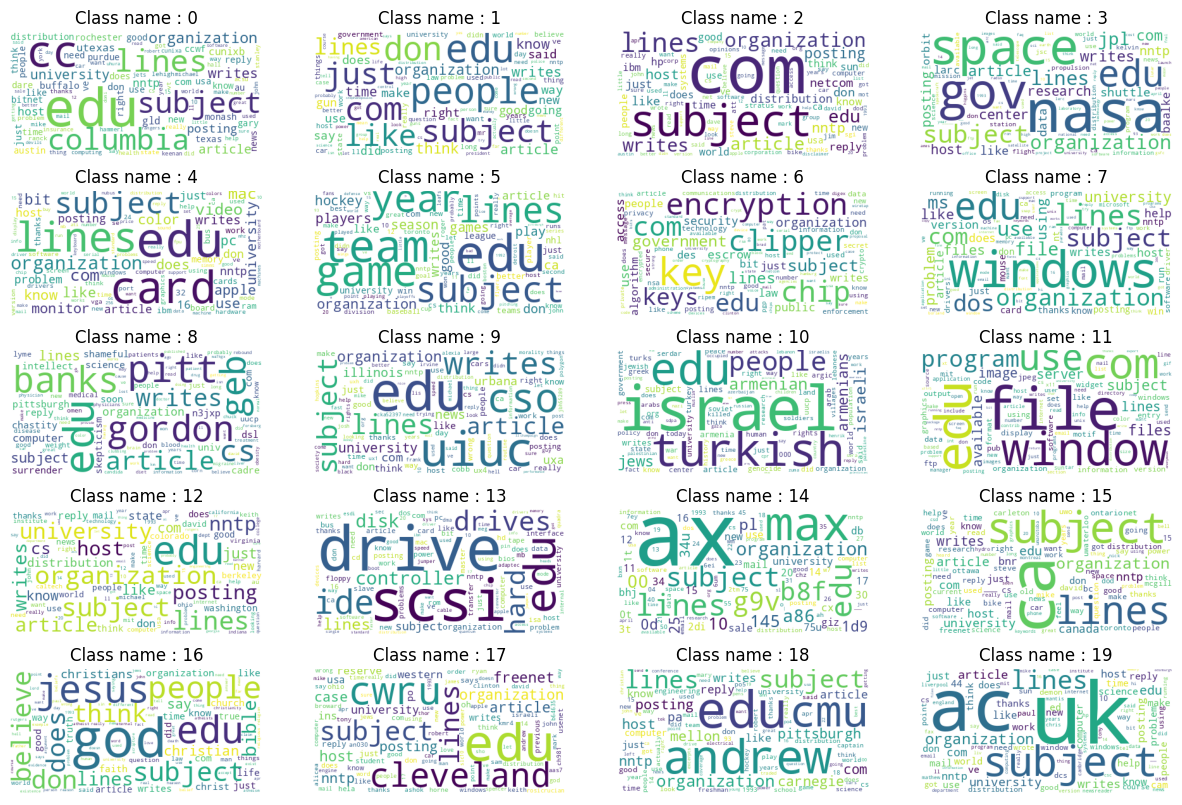

In [34]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
ax = ax.flatten()
unique_classes = np.unique(pred)
for i, class_name in enumerate(unique_classes):
    class_idx = pred[pred==class_name].index

    vectorizer2 = CountVectorizer(stop_words="english")
    tmp = vectorizer2.fit_transform(data[class_idx])
    freq_dict = pd.Series(np.array(tmp.sum(axis=0))[0], index = sorted(vectorizer2.vocabulary_))
    wordcloud = WordCloud(
        background_color='white',
        stopwords = STOPWORDS,
        max_words=100).generate_from_frequencies(frequencies=freq_dict)
    ax[i].imshow(wordcloud)
    ax[i].axis("off")
    ax[i].set_title(f"Class name : {class_name}")

**On retrouve un peu les mêmes nuages que précédement !**

* La nasa
* Jesus
* Windows
* Israel/turkish

## Quantitative Analysis

In [35]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [36]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, vectors, name="KMeans\non tf-idf vectors")

clustering done in 2.78 ± 2.65 s 
Homogeneity: 0.271 ± 0.014
Completeness: 0.311 ± 0.016
V-measure: 0.289 ± 0.015
Adjusted Rand-Index: 0.108 ± 0.010
Silhouette Coefficient: 0.023 ± 0.002


# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


## Computing LSA factorization 

On réduit égalise le nombre de dimension aux nombre de cluster souhaité

In [26]:
from sklearn.decomposition import TruncatedSVD
LSA = TruncatedSVD(n_components=true_k, algorithm='arpack', random_state=42).fit(vectors)
LSA_vectors = LSA.transform(vectors)
explained_variance = LSA.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 12.1%


### Attribute identification

In [27]:
print(f"""
Vectors : {vectors.shape},
Components : {LSA.components_.shape},
singular value : {LSA.singular_values_.shape}
""")
U = LSA.components_


Vectors : (11314, 1000),
Components : (20, 1000),
singular value : (20,)



En analysant les shapes, je déduits que `components_` est équivalent à $U$

## Qualitative Evaluation

### Les 20 mots les plus importants pour chaque cluster

In [28]:
for i in range(15, true_k):
    display(pd.Series(U[i,:], index=vectorizer.vocabulary_.keys()).sort_values(ascending=False).head(5))

michael     0.315056
49          0.246695
44          0.226383
isn         0.220525
illinois    0.176305
dtype: float64

stop      0.231940
course    0.203756
making    0.151655
gun       0.151094
half      0.150355
dtype: float64

uses        0.281015
says        0.248099
29          0.240940
44          0.232298
illinois    0.208381
dtype: float64

argument    0.487918
problems    0.363955
48          0.134588
similar     0.122499
fact        0.117308
dtype: float64

uses       0.272842
outside    0.266792
29         0.240966
uucp       0.177885
eric       0.176829
dtype: float64

It change at every run, pas ouf le kmean

### Quantitative

In [32]:
def fit_and_evaluate_SVD(km, X, y_hat, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, y_hat))
        scores["Completeness"].append(metrics.completeness_score(labels, y_hat))
        scores["V-measure"].append(metrics.v_measure_score(labels, y_hat))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, y_hat)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, y, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

In [34]:
fit_and_evaluate_SVD(TruncatedSVD(n_components=true_k, algorithm='arpack'), vectors, labels, n_runs=1, name='SVD_arpack')

clustering done in 1.39 ± 0.00 s 
Homogeneity: 1.000 ± 0.000
Completeness: 1.000 ± 0.000
V-measure: 1.000 ± 0.000
Adjusted Rand-Index: 1.000 ± 0.000
Silhouette Coefficient: 0.010 ± 0.000


## t-SNE viz

In [21]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

ValueError: perplexity must be less than n_samples

In [ ]:
NN2cluster = np.argmax(np.abs(vectors_SVDn), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [ ]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



## LDA-viz

In [ ]:
# pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**